## Importar librerias

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [ ]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Noticias_BCRP/notebooks/")

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from gensim.models import word2vec
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm, model_selection
from  datetime import datetime
from sklearn.metrics import roc_curve,auc, classification_report,confusion_matrix
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import load_model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
import lightgbm as lgb

## Cargar  train y test

In [ ]:
df_train=pd.read_pickle("../data/preprocessed/df_train.pkl")
df_test=pd.read_pickle("../data/preprocessed/df_test.pkl")

In [ ]:
y_train=df_train["Target"]
y_test=df_test["Target"]

In [ ]:
news_train=[ i for i in df_train["Clean_Stopword_Info"]]
news_test=[ i for i in df_test["Clean_Stopword_Info"]]

## Vectorizacion de noticias Tfidf

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
tf_idf_train = vectorizer.fit_transform(news_train)
tf_idf_test = vectorizer.transform(news_test)
tf_idf_train = tf_idf_train.toarray()
tf_idf_test = tf_idf_test.toarray()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000)
tf_idf_train = vectorizer.fit_transform(news_train)
tf_idf_test = vectorizer.transform(news_test)
tf_idf_train = tf_idf_train.toarray()
tf_idf_test = tf_idf_test.toarray()
pd.DataFrame(tf_idf_train)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.218838,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.10566,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.318109,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.112773,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.151986,0.0,0.0,0.0,0.0,0.0,0.0,0.149261,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.049005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.047235,0.0
4,0.032018,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.033394,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.286774,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48952,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.232087,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
48953,0.000000,0.0,0.447858,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.108476,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
48954,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
48955,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

#### Light GBM

In [ ]:
train_data=lgb.Dataset(tf_idf_train,label = y_train)
### definir los parámetros del modelo
param = {'num_leaves':150,'objective':'binary','max_depth':7,'learning_rate':0.01,'max_bin':200}
param['metric'] =['auc','binary_logloss']
num_round=500
start = datetime.now()
### entrenar el modelo Ligh GBM
lg_model=lgb.train(param,train_data,num_round)
stop=datetime.now()
execution_time_lg=stop-start
execution_time_lg

datetime.timedelta(0, 70, 403959)

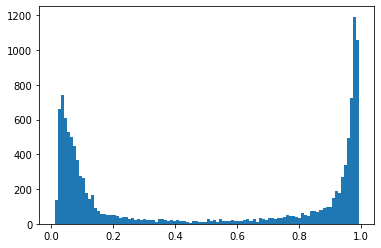

In [ ]:
pred_lg=lg_model.predict(tf_idf_test)
plt.hist(pred_lg,bins=100)
plt.show()

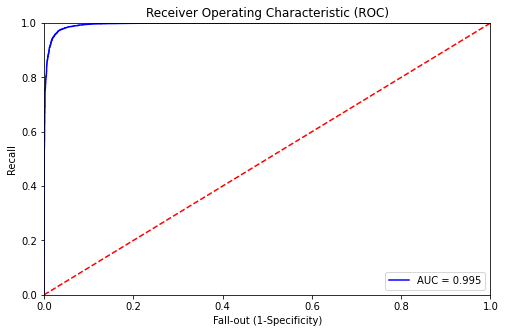

AUC score: 0.9953988758008478


In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_lg)
roc_auc_lg = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_lg)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_lg)

In [ ]:
### prediccion del modelo
pred_lg[pred_lg>=0.5]=1
pred_lg[pred_lg<0.5]=0
print(classification_report(y_test, pred_lg))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      6056
           1       0.97      0.96      0.97      6184

    accuracy                           0.97     12240
   macro avg       0.97      0.97      0.97     12240
weighted avg       0.97      0.97      0.97     12240



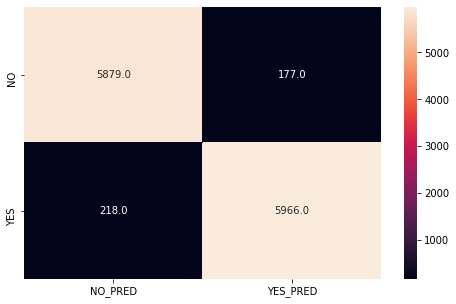

In [ ]:
### matriz de confusion
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_lg, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Support Vector Machine

In [ ]:
def svc_param(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10,100]
    gammas = [0.000001, 0.0001, 0.01, 1]
    kernels = ['rbf','linear']
    param_grid = {'C': Cs, 'gamma' : gammas,'kernel':kernels}
    grid_search = model_selection.GridSearchCV(svm.SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [ ]:
start = datetime.now()
# fitting=svc_param(promVect_train, Y_train, 5)
# model = svm.SVC(C=fitting['C'],gamma=fitting['gamma'],kernel=fitting['kernel'],probability=True)
svm_model = svm.SVC(C=100,gamma=0.01,kernel="rbf",probability=True)
svm_model.fit(tf_idf_train,y_train)
stop=datetime.now()
execution_time_svm=stop-start
execution_time_svm

datetime.timedelta(0, 1195, 447397)

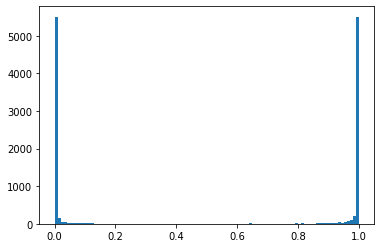

In [ ]:
pred_svm = svm_model.predict_proba(tf_idf_test)[:,-1]
plt.hist(pred_svm,bins=100)
plt.show()

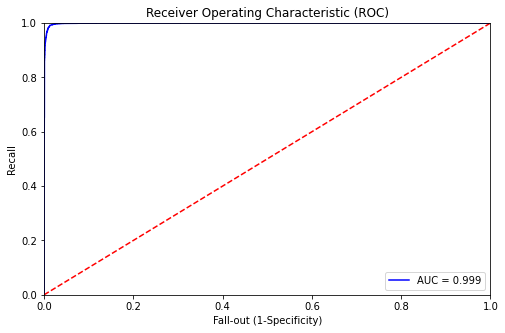

AUC score: 0.9989218512084708


In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_svm)
roc_auc_svm = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_svm)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_svm)

In [ ]:
### prediccion del modelo
pred_svm[pred_svm>=0.5]=1
pred_svm[pred_svm<0.5]=0
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



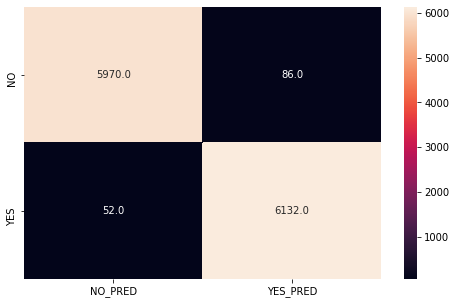

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_svm, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Redes Neuronales

In [ ]:
one_hot =[]
for i in y_train:
    aux=[]
    for j in [0,1]:
        if i==j:
            aux.append(1)
        else:
            aux.append(0)
    one_hot.append(aux)
one_hot = np.array(one_hot)

In [ ]:
model_rnn = Sequential()
model_rnn.add(Dense(1024,input_dim=len(tf_idf_train[0]),activation="relu"))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(512,activation="relu"))
model_rnn.add(Dense(len(one_hot[0]),activation="sigmoid"))

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_rnn.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [2]:
61197*0.2

12239.400000000001

In [ ]:
start=datetime.now()
model_rnn.fit(tf_idf_train,one_hot,epochs=20,batch_size=64)
stop=datetime.now()
execution_time_rnn=stop-start
execution_time_rnn

Epoch 1/20
48957/48957 [==============================] - 19s 382us/step - loss: 0.0425 - accuracy: 0.9864
Epoch 2/20
48957/48957 [==============================] - 18s 370us/step - loss: 0.0292 - accuracy: 0.9909
Epoch 3/20
48957/48957 [==============================] - 18s 372us/step - loss: 0.0276 - accuracy: 0.9916
Epoch 4/20
48957/48957 [==============================] - 18s 367us/step - loss: 0.0268 - accuracy: 0.9919
Epoch 5/20
48957/48957 [==============================] - 18s 363us/step - loss: 0.0267 - accuracy: 0.9921
Epoch 6/20
48957/48957 [==============================] - 18s 362us/step - loss: 0.0264 - accuracy: 0.9921
Epoch 7/20
48957/48957 [==============================] - 18s 363us/step - loss: 0.0261 - accuracy: 0.9923
Epoch 8/20
48957/48957 [==============================] - 18s 361us/step - loss: 0.0259 - accuracy: 0.9924
Epoch 9/20
48957/48957 [==============================] - 18s 363us/step - loss: 0.0259 - accuracy: 0.9923
Epoch 10/20
48957/48957 [============

datetime.timedelta(0, 355, 770526)

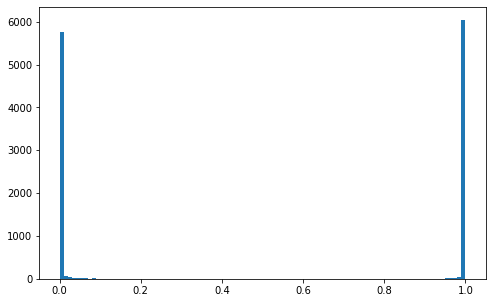

In [ ]:
pred_rnn=model_rnn.predict_proba(tf_idf_test)[:,-1]
plt.hist(pred_rnn,bins=100)
plt.show()

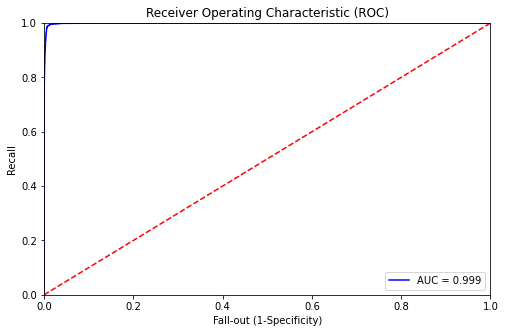

AUC score: 0.9990091669215825


In [ ]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_rnn)
roc_auc_rnn = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_rnn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_rnn)

In [ ]:
### prediccion del modelo
pred_rnn[pred_rnn>=0.5]=1
pred_rnn[pred_rnn<0.5]=0
print(classification_report(y_test, pred_rnn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



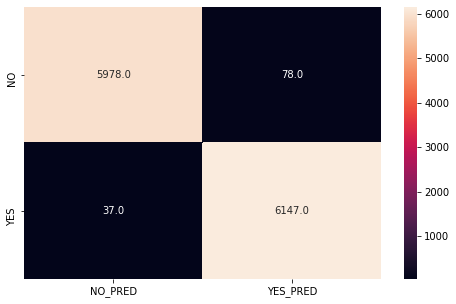

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_rnn, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

## Tf_idf EXample

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = ['This is the first document.',
     'This document is the second document.',
     'And this is the third one.',
     'Is this the first document?', ]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
# display(print(X))
pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())

,and,document,first,is,one,second,the,third,this
0,0.000000,0.469791,0.580286,0.384085,0.000000,0.000000,0.384085,0.000000,0.384085
1,0.000000,0.687624,0.000000,0.281089,0.000000,0.538648,0.281089,0.000000,0.281089
2,0.511849,0.000000,0.000000,0.267104,0.511849,0.000000,0.267104,0.511849,0.267104
3,0.000000,0.469791,0.580286,0.384085,0.000000,0.000000,0.384085,0.000000,0.384085


In [ ]:
vectorizer.idf_

array([1.91629073, 1.22314355, 1.51082562, 1.        , 1.91629073,
       1.91629073, 1.        , 1.91629073, 1.        ])

In [ ]:
import nltk
from collections import Counter
from nltk import word_tokenize
# nltk.download("punkt")
Counter([i for i in word_tokenize(" ".join(corpus).lower()) if i.isalpha()])

Counter({'and': 1,
         'document': 4,
         'first': 2,
         'is': 4,
         'one': 1,
         'second': 1,
         'the': 4,
         'third': 1,
         'this': 4})

In [ ]:
math.log((1+4)/(1+3))+1

1.2231435513142097

In [ ]:
import math

In [ ]:
1*1+1*1+1*1+1*1.51082562+1*1.22314355
math.sqrt(1*1+1*1+1*1+1*1.51082562**2+1*1.22314355**2)

2.6035887152073363

In [ ]:
1/2.6035887152073363

0.3840852413282815